In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%cd ..
%pwd

/home/markus/Documents/regression-prediction


'/home/markus/Documents/regression-prediction'

In [3]:
from src.utils import *
from experiments.data_utils import *
from experiments.plot_utils import *
from experiments.hyperparam_tuning import *
from sklearn.model_selection import cross_val_score


/home/markus/Documents/regression-prediction/venv/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [8]:
target = 'performance' # performance, regression
data = 'bugbug_buglevel' # bugbug_buglevel, bugbug_szz, fixed_defect_szz
scoring = 'average_precision' # roc_auc, average_precision
model = 'svm' # lr, svm, mlp, rf, xgb
feature_type = 'traditional' # traditional, bow

In [5]:
output_dir = 'experiments/results'

In [6]:
data_map = {}

data_map['traditional'] = {
    'bugbug_buglevel': lambda target: get_ml_data_traditional('bugbug', target, kind='buglevel'),
    'bugbug_szz': lambda target: get_ml_data_traditional('bugbug_szz', target, kind='commitlevel'),
    'fixed_defect_szz': lambda target: get_ml_data_traditional('fixed_defect_szz', target, kind='commitlevel')
}
data_map['bow'] = {
    'bugbug_buglevel': lambda target: get_ml_data_bow('bugbug', target, kind='buglevel'),
    'bugbug_szz': lambda target: get_ml_data_bow('bugbug_szz', target, kind='commitlevel'),
    'fixed_defect_szz': lambda target: get_ml_data_bow('fixed_defect_szz', target, kind='commitlevel')
}

In [9]:
def get_results(data, feature_type, target, scoring, model):
    path = os.path.join(output_dir, f'{data}_{feature_type}_{target}_{scoring}_{model}.csv')
    results = pd.read_csv(path, index_col=0)
    if model == 'svm':
        results = results.drop('param_kernel__gamma', axis=1, errors='ignore')
    results = results.replace({np.nan: None})
    return results
results = get_results(data, feature_type, target, scoring, model)
results

,param_kernel__degree,param_kernel__kernel,param_model,param_model__C,param_sampler,mean_fit_time,std_fit_time,mean_test_score,std_test_score,rank_test_score
60,5,linear,LinearSVC,7.156091,None,92.779359,15.309179,0.075568,0.036241,1
82,5,linear,LinearSVC,6.611158,None,265.980683,47.826468,0.074486,0.033193,2
83,3,linear,LinearSVC,6.625197,None,229.334673,49.624527,0.073971,0.033777,3
84,5,linear,LinearSVC,6.616933,None,271.594698,51.639257,0.073833,0.033695,4
81,5,linear,LinearSVC,6.599619,None,236.065617,45.443243,0.073514,0.033714,5
...,...,...,...,...,...,...,...,...,...,...
7,5,poly,LinearSVC,0.000234,RandomUnderSampler(random_state=0),0.759276,0.119223,0.052808,0.024991,96
13,5,rbf,LinearSVC,0.000759,RandomOverSampler(random_state=0),5.570215,0.929523,0.051968,0.024092,97
9,3,poly,LinearSVC,0.000310,RandomOverSampler(random_state=0),5.971903,1.155938,0.051959,0.024585,98
51,5,rbf,LinearSVC,0.000102,SMOTE(random_state=0),9.366144,1.502797,0.050986,0.023530,99


In [10]:
X, y, features = data_map[feature_type][data](target)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=False)

performance: 1452 positive 2.41% - negative 58910 97.59%
X.shape=(60362, 302)



In [11]:
def get_params(results):
    params = results[[c for c in results.columns if 'param' in c]]
    params = params.rename(lambda c: c[6:], axis=1) # remove param_
    return params
params = get_params(results)

In [12]:
model_map = {
    'lr': LogisticRegression(random_state=0, solver='saga'),
    'svm': LinearSVC(random_state=0),
    'mlp': MLPClassifier(random_state=0),
    'rf': RandomForestClassifier(random_state=0),
    'xgb': xgboost.XGBClassifier(random_state=0, n_jobs=4, use_label_encoder=False, eval_metric='logloss')
}
model_names = {
    'lr': 'Logistic Regression',
    'svm': 'Support Vector Machine',
    'rf': 'Random Forest',
    'xgb': 'XGBoost',
    'mlp': 'Multi-Layer Perceptron',
    'tpot': 'TPOT'
}
models = list(model_names.keys())

In [13]:
def get_best_params(model, params):
    best_params = dict(params.iloc[0])

    best_params['model'] = model_map[model]
    try:
        best_params['sampler'] = eval(best_params['sampler'])
    except:
        best_params['sampler'] = None
    
    return best_params

best_params = get_best_params(model, params)
best_params

{'kernel__degree': 5,
 'kernel__kernel': 'linear',
 'model': LinearSVC(random_state=0),
 'model__C': 7.156090624884973,
 'sampler': None}

In [14]:
pipeline = default_pipeline() if model != 'svm' else svm_pipeline()
pipeline.set_params(**best_params)
pipeline

Pipeline(steps=[('scaler', MinMaxScaler()), ('sampler', None),
                ('kernel',
                 Nystroem(degree=5, kernel='linear', n_components=500,
                          random_state=0)),
                ('model', LinearSVC(C=7.156090624884973, random_state=0))])

In [15]:
results.iloc[0]

param_kernel__degree            5
param_kernel__kernel       linear
param_model             LinearSVC
param_model__C           7.156091
param_sampler                None
mean_fit_time           92.779359
std_fit_time            15.309179
mean_test_score          0.075568
std_test_score           0.036241
rank_test_score                 1
Name: 60, dtype: object

In [16]:
def get_best_f1_threshold(clf, X, y):
    y_score = get_y_score(clf, X)
    precision, recall, thresholds = metrics.precision_recall_curve(y, y_score)
    precision = precision[:-1] # last one is 0
    recall = recall[:-1] # last one is 1

    D = precision + recall
    P = precision[D != 0]
    R = recall[D != 0]
    F1 = 2 * P * R / D[D != 0]
    T = thresholds[D != 0]

    amax = F1.argmax()
    return T[amax], F1[amax]

In [17]:
def get_tpot_pipeline(data, feature_type, target, scoring):
    import re
    from tpot.export_utils import set_param_recursive
    path = os.path.join(output_dir, f'{data}_{feature_type}_{target}_{scoring}_tpot_exported_pipeline.py')

    with open(path,'r') as f:
        exported_pipeline_str = f.read()
        import_lines = []
        pipeline_lines = []
        state = 0
        for line in exported_pipeline_str.splitlines():
            if len(line) == 0:
                continue
            if line[0] == '#':
                state += 1
                continue
                
            if state == 0:
                import_lines.append(line)
            if state == 2:
                pipeline_lines.append(line)

        import_statements = '\n'.join(import_lines)
        exec(import_statements)
        pipeline_statements = '\n'.join(pipeline_lines)

        exported_pipeline = eval(pipeline_statements[20:]) 
        set_param_recursive(exported_pipeline.steps, 'random_state', 0)

        score = float(re.findall('Average CV score on the training set was: ([\d.]+)', exported_pipeline_str)[0])
        return exported_pipeline, None, score


In [19]:
def get_pipeline(data, feature_type, target, scoring, model):
    if model == 'tpot':
        return get_tpot_pipeline(data, feature_type, target, scoring)
        
    results = get_results(data, feature_type, target, scoring, model)
    best_result = results.iloc[0]
    params = get_params(results)
    best_params = get_best_params(model, params)

    pipeline = default_pipeline() if model != 'svm' else svm_pipeline()
    pipeline.set_params(**best_params)
    if feature_type == 'bow':
        pipeline.set_params(scaler=None)

    return pipeline, best_params, best_result['mean_test_score']

from sklearn.model_selection import cross_validate
def evaluate_pipeline(model, target, data, feature_type, scoring, X_train, y_train, X_test, y_test):
    evaluation = {'model': model}

    pipeline, best_params, best_result = get_pipeline(data, feature_type, target, scoring, model)

    y_test_proportion = len(y_test) / (len(y_train) + len(y_test))
    tscv = TimeSeriesSplit(n_splits=5, test_size=round(len(y_train) * y_test_proportion))
    res = cross_validate(pipeline, X_train, y_train, scoring=['average_precision', 'roc_auc'], cv=tscv, n_jobs=5)
    evaluation['validation'] = res
    
    pipeline.fit(X_train, y_train)
    evaluation['fitted_pipeline'] = pipeline
    evaluation['best_params'] = best_params
    evaluation['best_result'] = best_result

    threshold_train, f1_train = get_best_f1_threshold(pipeline, X_train, y_train)
    threshold_test, f1_test = get_best_f1_threshold(pipeline, X_test, y_test)
    print(f'{threshold_train=} {f1_train=}, {threshold_test=}, {f1_test=}')

    for (split, X_, y_, threshold) in [
        ('train', X_train, y_train, threshold_train),
        ('test', X_test, y_test, threshold_train),
        ('test_pareto', X_test, y_test, threshold_test)
        ]:

        y_score = get_y_score(pipeline, X_)
        y_pred = y_score >= threshold

        evaluation[split] = {
            'average_precision': metrics.average_precision_score(y_, y_score),
            'roc_auc': metrics.roc_auc_score(y_, y_score),

            'regression': {
                'recall': metrics.recall_score(y_, y_pred, pos_label=1),
                'precision': metrics.precision_score(y_, y_pred, pos_label=1),
                'f1': metrics.f1_score(y_, y_pred, pos_label=1)
            },
            'non-regression': {
                'recall': metrics.recall_score(y_, y_pred, pos_label=0),
                'precision': metrics.precision_score(y_, y_pred, pos_label=0),
                'f1': metrics.f1_score(y_, y_pred, pos_label=0)
            },
            'avg_micro': {
                'recall': metrics.recall_score(y_, y_pred, average='micro'),
                'precision': metrics.precision_score(y_, y_pred, average='micro'),
                'f1': metrics.f1_score(y_, y_pred, average='micro')
            },
            'avg_macro': {
                'recall': metrics.recall_score(y_, y_pred, average='macro'),
                'precision': metrics.precision_score(y_, y_pred, average='macro'),
                'f1': metrics.f1_score(y_, y_pred, average='macro')
            }
        }

    
    return evaluation

def evaluate_pipelines(target, data, feature_type, scoring, X_train, y_train, X_test, y_test):
    evaluations = []
    for model in models:
        print(model)
        try:
            evaluation = evaluate_pipeline(model, target, data, feature_type, scoring, X_train, y_train, X_test, y_test)
            evaluations.append(evaluation)
        except Exception as e:
            print(e)

    return evaluations


In [20]:
target = 'performance' # performance, regression
data = 'bugbug_buglevel' # bugbug_buglevel, bugbug_szz, fixed_defect_szz
scoring = 'average_precision' # roc_auc, average_precision
feature_type = 'traditional' # traditional, bow

X, y, features = data_map[feature_type][data](target)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=False)

evaluation = evaluate_pipeline('tpot', target, data, feature_type, scoring, X_train, y_train, X_test, y_test)

performance: 1452 positive 2.41% - negative 58910 97.59%
X.shape=(60362, 302)



/home/markus/Documents/regression-prediction/venv/lib/python3.8/site-packages/tpot/builtins/__init__.py:36: UserWarning: Warning: optional dependency `torch` is not available. - skipping import of NN models.
  warnings.warn("Warning: optional dependency `torch` is not available. - skipping import of NN models.")
/home/markus/Documents/regression-prediction/venv/lib/python3.8/site-packages/tpot/builtins/__init__.py:36: UserWarning: Warning: optional dependency `torch` is not available. - skipping import of NN models.
  warnings.warn("Warning: optional dependency `torch` is not available. - skipping import of NN models.")
/home/markus/Documents/regression-prediction/venv/lib/python3.8/site-packages/tpot/builtins/__init__.py:36: UserWarning: Warning: optional dependency `torch` is not available. - skipping import of NN models.
  warnings.warn("Warning: optional dependency `torch` is not available. - skipping import of NN models.")
/home/markus/Documents/regression-prediction/venv/lib/pyth

threshold_train=0.20587698412698402 f1_train=0.8953341740226985, threshold_test=0.0964202741702742, f1_test=0.14958448753462605


In [83]:
target = 'regression' # performance, regression
data = 'bugbug_buglevel' # bugbug_buglevel, bugbug_szz, fixed_defect_szz
scoring = 'average_precision' # roc_auc, average_precision
feature_type = 'traditional' # traditional, bow

X, y, features = data_map[feature_type][data](target)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=False)

evaluations = evaluate_pipelines(target, data, feature_type, scoring, X_train, y_train, X_test, y_test)

regression: 11552 positive 19.14% - negative 48810 80.86%
X.shape=(60362, 302)

lr


/home/markus/Documents/regression-prediction/venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/markus/Documents/regression-prediction/venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/markus/Documents/regression-prediction/venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/markus/Documents/regression-prediction/venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/markus/Documents/regression-prediction/venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was

threshold_train=0.5208349722252273 f1_train=0.41217438146908303, threshold_test=0.49238361926025925, f1_test=0.4009433962264151
svm


/home/markus/Documents/regression-prediction/venv/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/markus/Documents/regression-prediction/venv/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/markus/Documents/regression-prediction/venv/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/markus/Documents/regression-prediction/venv/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/markus/Documents/regression-prediction/venv/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the numb

threshold_train=-0.6473181662708214 f1_train=0.4229733318159402, threshold_test=-0.7068722397784022, f1_test=0.40859030837004406
rf
threshold_train=0.242264037651031 f1_train=0.8098256735340729, threshold_test=0.211431877591684, f1_test=0.41751061744527934
xgb


/home/markus/Documents/regression-prediction/venv/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/home/markus/Documents/regression-prediction/venv/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/home/markus/Documents/regression-prediction/venv/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/home/markus/Documents/regression-prediction/venv/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWar

threshold_train=0.2295654 f1_train=0.48072155253483795, threshold_test=0.20096798, f1_test=0.4248132510555375
mlp


/home/markus/Documents/regression-prediction/venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/markus/Documents/regression-prediction/venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/markus/Documents/regression-prediction/venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/markus/Documents/regression-prediction/venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) 

threshold_train=0.5552175944156519 f1_train=0.4367091041963152, threshold_test=0.5152308280419579, f1_test=0.40550029256875364
tpot


/home/markus/Documents/regression-prediction/venv/lib/python3.8/site-packages/tpot/builtins/__init__.py:36: UserWarning: Warning: optional dependency `torch` is not available. - skipping import of NN models.
  warnings.warn("Warning: optional dependency `torch` is not available. - skipping import of NN models.")
/home/markus/Documents/regression-prediction/venv/lib/python3.8/site-packages/tpot/builtins/__init__.py:36: UserWarning: Warning: optional dependency `torch` is not available. - skipping import of NN models.
  warnings.warn("Warning: optional dependency `torch` is not available. - skipping import of NN models.")
/home/markus/Documents/regression-prediction/venv/lib/python3.8/site-packages/tpot/builtins/__init__.py:36: UserWarning: Warning: optional dependency `torch` is not available. - skipping import of NN models.
  warnings.warn("Warning: optional dependency `torch` is not available. - skipping import of NN models.")
/home/markus/Documents/regression-prediction/venv/lib/pyth

threshold_train=0.3330501313462426 f1_train=0.9007963010531723, threshold_test=0.2199151412313177, f1_test=0.4278745644599304


In [84]:
def get_overfit_stat_df(evaluation):
    columns = [
        np.array(['train', 'train', 'validation', 'validation', 'test', 'test']),
        np.array(['Avg. Precision', 'AUC', 'Avg. Precision', 'AUC', 'Avg. Precision', 'AUC']),
    ]

    df = pd.DataFrame([[
        evaluation['train']['average_precision'],
        evaluation['train']['roc_auc'],
        evaluation['validation']['test_average_precision'].mean(),
        evaluation['validation']['test_roc_auc'].mean(),
        evaluation['test']['average_precision'],
        evaluation['test']['roc_auc']
        ]],
        index=[model_names[evaluation['model']]],
        columns=columns)
    return df

In [85]:
pd.set_option("display.precision", 4)

overfit_stats = pd.concat(
    [get_overfit_stat_df(evaluation) for evaluation in evaluations],
     axis=0)
overfit_stats

train             validation          \
                       Avg. Precision     AUC Avg. Precision     AUC   
Logistic Regression            0.3747  0.6865         0.3608  0.6715   
Support Vector Machine         0.3906  0.6983         0.3673  0.6783   
Random Forest                  0.8721  0.9334         0.3974  0.6909   
XGBoost                        0.5093  0.7572         0.4021  0.6969   
Multi-Layer Perceptron         0.4153  0.7165         0.3687  0.6798   
TPOT                           0.9473  0.9787         0.4014  0.6990   

                                 test          
                       Avg. Precision     AUC  
Logistic Regression            0.3608  0.6774  
Support Vector Machine         0.3657  0.6861  
Random Forest                  0.3917  0.6956  
XGBoost                        0.4111  0.7113  
Multi-Layer Perceptron         0.3623  0.6847  
TPOT                           0.4101  0.7028

In [86]:
print(overfit_stats.to_latex())

\begin{tabular}{lrrrrrr}
\toprule
{} & \multicolumn{2}{l}{train} & \multicolumn{2}{l}{validation} & \multicolumn{2}{l}{test} \\
{} & Avg. Precision &     AUC & Avg. Precision &     AUC & Avg. Precision &     AUC \\
\midrule
Logistic Regression    &         0.3747 &  0.6865 &         0.3608 &  0.6715 &         0.3608 &  0.6774 \\
Support Vector Machine &         0.3906 &  0.6983 &         0.3673 &  0.6783 &         0.3657 &  0.6861 \\
Random Forest          &         0.8721 &  0.9334 &         0.3974 &  0.6909 &         0.3917 &  0.6956 \\
XGBoost                &         0.5093 &  0.7572 &         0.4021 &  0.6969 &         0.4111 &  0.7113 \\
Multi-Layer Perceptron &         0.4153 &  0.7165 &         0.3687 &  0.6798 &         0.3623 &  0.6847 \\
TPOT                   &         0.9473 &  0.9787 &         0.4014 &  0.6990 &         0.4101 &  0.7028 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_285/1979448124.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(overfit_stats.to_latex())


In [87]:
def get_classification_report_df(evaluation):
    dfs = []
    for split in ['train', 'test', 'test_pareto']:
        df = pd.DataFrame(
            [
                evaluation[split]['regression'],
                evaluation[split]['non-regression'],
                evaluation[split]['avg_macro'],
                evaluation[split]['avg_micro']
            ],
            index=[
                [model_names[evaluation['model']]]*4,
                ['regression', 'non-regression', 'macro average', 'micro average']
                ]
        )
        df.columns = [
            np.array([split]*3),
            np.array(['recall', 'precision', 'F1'])
        ]
        dfs.append(df)

    classification_reports = pd.concat(dfs, axis=1)

    return classification_reports

In [88]:
pd.set_option("display.precision", 4)
classification_reports = pd.concat(
    [get_classification_report_df(evaluation) for evaluation in evaluations],
     axis=0)
classification_reports

train                      test  \
                                       recall precision      F1  recall   
Logistic Regression    regression      0.5141    0.3440  0.4122  0.5300   
                       non-regression  0.7673    0.8694  0.8152  0.7336   
                       macro average   0.6407    0.6067  0.6137  0.6318   
                       micro average   0.7188    0.7188  0.7188  0.6954   
Support Vector Machine regression      0.5351    0.3497  0.4230  0.5397   
                       non-regression  0.7639    0.8738  0.8152  0.7289   
                       macro average   0.6495    0.6118  0.6191  0.6343   
                       micro average   0.7200    0.7200  0.7200  0.6934   
Random Forest          regression      0.7357    0.9005  0.8098  0.4824   
                       non-regression  0.9807    0.9399  0.9599  0.7954   
                       macro average   0.8582    0.9202  0.8849  0.6389   
                       micro average   0.9337    0.9337  0.9337  0.7366   
XGBoost                regression      0.5397    0.4333  0.4807  0.5053   
                       non-regression  0.8325    0.8840  0.8575  0.7865   
                       macro average   0.6861    0.6587  0.6691  0.6459   
                       micro average   0.7764    0.7764  0.7764  0.7336   
Multi-Layer Perceptron regression      0.5449    0.3644  0.4367  0.5344   
                       non-regression  0.7744    0.8776  0.8228  0.7406   
                       macro average   0.6597    0.6210  0.6298  0.6375   
                       micro average   0.7304    0.7304  0.7304  0.7018   
TPOT                   regression      0.8415    0.9691  0.9008  0.3325   
                       non-regression  0.9936    0.9635  0.9783  0.9117   
                       macro average   0.9176    0.9663  0.9396  0.6221   
                       micro average   0.9645    0.9645  0.9645  0.8029   

                                                        test_pareto            \
                                      precision      F1      recall precision   
Logistic Regression    regression        0.3152  0.3953      0.5996    0.3012   
                       non-regression    0.8709  0.7964      0.6782    0.8799   
                       macro average     0.5930  0.5958      0.6389    0.5905   
                       micro average     0.6954  0.6954      0.6634    0.6634   
Support Vector Machine regression        0.3153  0.3980      0.6543    0.2970   
                       non-regression    0.8726  0.7943      0.6419    0.8892   
                       macro average     0.5939  0.5962      0.6481    0.5931   
                       micro average     0.6934  0.6934      0.6442    0.6442   
Random Forest          regression        0.3529  0.4076      0.5635    0.3316   
                       non-regression    0.8692  0.8307      0.7373    0.8796   
                       macro average     0.6110  0.6191      0.6504    0.6056   
                       micro average     0.7366  0.7366      0.7047    0.7047   
XGBoost                regression        0.3537  0.4161      0.5767    0.3362   
                       non-regression    0.8730  0.8275      0.7367    0.8827   
                       macro average     0.6133  0.6218      0.6567    0.6095   
                       micro average     0.7336  0.7336      0.7066    0.7066   
Multi-Layer Perceptron regression        0.3227  0.4024      0.6111    0.3034   
                       non-regression    0.8730  0.8014      0.6755    0.8825   
                       macro average     0.5979  0.6019      0.6433    0.5930   
                       micro average     0.7018  0.7018      0.6634    0.6634   
TPOT                   regression        0.4654  0.3879      0.5414    0.3537   
                       non-regression    0.8552  0.8825      0.7712    0.8791   
                       macro average     0.6603  0.6352      0.6563    0.6164   
                       micro average     0.8029  0.8029      0.7

In [89]:
print(classification_reports.to_latex())

\begin{tabular}{llrrrrrrrrr}
\toprule
     &               & \multicolumn{3}{l}{train} & \multicolumn{3}{l}{test} & \multicolumn{3}{l}{test\_pareto} \\
     &               &  recall & precision &      F1 &  recall & precision &      F1 &      recall & precision &      F1 \\
\midrule
Logistic Regression & regression &  0.5141 &    0.3440 &  0.4122 &  0.5300 &    0.3152 &  0.3953 &      0.5996 &    0.3012 &  0.4009 \\
     & non-regression &  0.7673 &    0.8694 &  0.8152 &  0.7336 &    0.8709 &  0.7964 &      0.6782 &    0.8799 &  0.7660 \\
     & macro average &  0.6407 &    0.6067 &  0.6137 &  0.6318 &    0.5930 &  0.5958 &      0.6389 &    0.5905 &  0.5834 \\
     & micro average &  0.7188 &    0.7188 &  0.7188 &  0.6954 &    0.6954 &  0.6954 &      0.6634 &    0.6634 &  0.6634 \\
Support Vector Machine & regression &  0.5351 &    0.3497 &  0.4230 &  0.5397 &    0.3153 &  0.3980 &      0.6543 &    0.2970 &  0.4086 \\
     & non-regression &  0.7639 &    0.8738 &  0.8152 &  0.7289 &  

/tmp/ipykernel_285/1312144155.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(classification_reports.to_latex())


In [90]:
fitted_pipelines = [(model_names[evaluation['model']], evaluation['fitted_pipeline']) for evaluation in evaluations]

In [91]:
def plot_roc_auc_rec_prec_for_all_models(target, data, feature_type, scoring,
    fitted_pipelines, X_train, X_test, y_train, y_test, split='test', save=False, figsize=(12,8)):

    if split == 'test':
        _X = X_test
        _y = y_test
    elif split == 'train':
        _X = X_train
        _y = y_train

    roc_fig, roc_ax = plt.subplots(figsize=figsize)
    roc_ax.axline([0,0], [1,1], color='black')
    roc_ax.set(xlabel='False Positive Rate', ylabel='True Positive Rate', title='ROC Curve')

    pr_fig, pr_ax = plt.subplots(figsize=figsize)
    R, P = np.meshgrid(np.linspace(0,1,100), np.linspace(0,1,100))
    F1 = 2 * R * P / (R + P)
    CS = pr_ax.contour(R, P, F1, levels=np.arange(0.1, 1, 0.1), alpha=0.5, colors='gray', label='F1 contours')
    pr_ax.clabel(CS, inline=1)
    pr_ax.set(xlabel='Recall', ylabel='Precision', title='Recall-Precision Curve')


    for (model, pipeline) in fitted_pipelines:
        y_score = get_y_score(pipeline, _X)

        fpr, tpr, thresholds = metrics.roc_curve(_y, y_score)
        roc_ax.plot(fpr, tpr, label=model)
        
        precision, recall, thresholds = metrics.precision_recall_curve(_y, y_score)
        pr_ax.plot(recall, precision, label=model)

    roc_ax.legend()
    pr_ax.legend()

    roc_fig.tight_layout()
    if save:
        roc_fig.savefig(f'experiments/plots/{data}_{feature_type}_{target}_{scoring}_roc_{split}.pdf')

    pr_fig.tight_layout()
    if save:
        pr_fig.savefig(f'experiments/plots/{data}_{feature_type}_{target}_{scoring}_pr_{split}.pdf')
    plt.show()


/tmp/ipykernel_285/2747395001.py:17: RuntimeWarning: invalid value encountered in true_divide
  F1 = 2 * R * P / (R + P)
/tmp/ipykernel_285/2747395001.py:18: UserWarning: The following kwargs were not used by contour: 'label'
  CS = pr_ax.contour(R, P, F1, levels=np.arange(0.1, 1, 0.1), alpha=0.5, colors='gray', label='F1 contours')


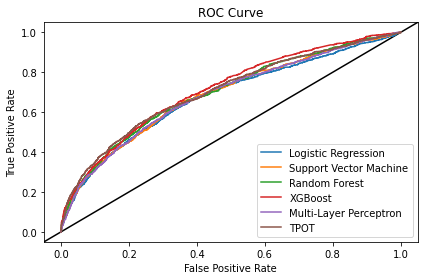

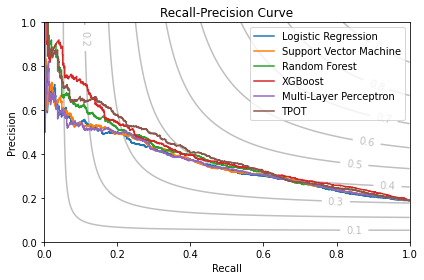

In [92]:
plot_roc_auc_rec_prec_for_all_models(target, data, feature_type, scoring,
    fitted_pipelines, X_train, X_test, y_train, y_test, save=True, figsize=(6,4))

In [ ]:
from sklearn.model_selection import cross_val_score
y_test_proportion = len(y_test) / (len(y_train) + len(y_test))
tscv = TimeSeriesSplit(n_splits=5, test_size=round(len(y_train) * y_test_proportion))
res = cross_val_score(pipeline, X_train, y_train, scoring=scoring, cv=tscv, n_jobs=5)
res, res.mean(), res.std()

In [ ]:
for ix_train, ix_val in tscv.split(X_train, y_train):
    print(f'{ix_train=}, {ix_val=}')
    print(f'{y_train[ix_train].sum()=}, {y_train[ix_val].sum()=}')
    pipeline.fit(X_train[ix_train, :], y_train[ix_train])

    y_score = pipeline.predict_proba(X_train[ix_val, :])[:,1]
    print('ROC AUC:', metrics.roc_auc_score(y_train[ix_val], y_score))
    print('AVG PREC:', metrics.average_precision_score(y_train[ix_val], y_score))
    plot_roc_curve(pipeline, X_train[ix_val, :], y_train[ix_val])
    plot_precision_recall_curve_with_f1(pipeline,  X_train[ix_val, :], y_train[ix_val])

In [ ]:
pipeline.fit(X_train, y_train)

In [ ]:
y_score = pipeline.predict_proba(X_train)[:,1]
metrics.roc_auc_score(y_train, y_score), metrics.average_precision_score(y_train, y_score)

In [ ]:
plot_roc_curve(pipeline, X_train, y_train)

In [ ]:
plot_precision_recall_curve_with_f1(pipeline, X_train, y_train)

In [ ]:
y_score = pipeline.predict_proba(X_test)[:,1]
metrics.roc_auc_score(y_test, y_score), metrics.average_precision_score(y_test, y_score)

In [ ]:
plot_roc_curve(pipeline, X_test, y_test)

In [ ]:
plot_precision_recall_curve_with_f1(pipeline, X_test, y_test)

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
plt.boxplot(results['mean_test_score'])

In [181]:
make_directory('experiments/plots')

In [182]:
def fit_best_model(model, data, feature_type, target, scoring, X_train, y_train):
    print(model)
    pipeline, best_params, best_result = get_pipeline(model, data, feature_type, target, scoring)
    print(best_params)
    pipeline.fit(X_train, y_train)
    return pipeline

def fit_all_models(target, data, feature_type, scoring):
    X, y, features = data_map[feature_type][data](target)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=False)

    fitted_pipelines = []
    for model in models:
        try:
            pipeline = fit_best_model(model, data, feature_type, target, scoring, X_train, y_train)
            fitted_pipelines.append((model, pipeline))
        except Exception as e:
            print(e)

    return fitted_pipelines, X_train, X_test, y_train, y_test
    

In [88]:
target = 'performance' # performance, regression
data = 'bugbug_buglevel' # bugbug_buglevel, bugbug_szz, fixed_defect_szz
scoring = 'average_precision' # roc_auc, average_precision

In [90]:
def print_classification_report_at_threshold(clf, X, y, threshold):
    y_score = get_y_score(clf, X)
    y_pred = y_score >= threshold
    print(f'{threshold=}')
    report = metrics.classification_report(y, y_pred)
    print(report)
    roc_auc = metrics.roc_auc_score(y, y_score)
    average_precision = metrics.average_precision_score(y, y_score)
    print(f'{roc_auc=} {average_precision=}')

In [35]:
fitted_pipelines, X_train, X_test, y_train, y_test = fit_all_models(target, data, feature_type, scoring)

performance: 1452 positive 2.41% - negative 58910 97.59%
X.shape=(60362, 302)

lr
{'model': LogisticRegression(C=5.402024656860861, random_state=0, solver='saga'), 'model__C': 0.021059163929894, 'model__penalty': 'l2', 'sampler': SMOTE(random_state=0)}
svm
{'kernel__degree': 5, 'kernel__kernel': 'linear', 'model': LinearSVC(C=164.87171291936357, random_state=0), 'model__C': 7.156090624884973, 'sampler': None}


/home/markus/Documents/regression-prediction/venv/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


mlp
{'model': MLPClassifier(alpha=0.0134505118791459, hidden_layer_sizes=100,
              learning_rate_init=0.0001, random_state=0), 'model__activation': 'tanh', 'model__alpha': 0.2431362008261892, 'model__hidden_layer_sizes': 200, 'model__learning_rate_init': 0.0041238725976079, 'sampler': SMOTE(random_state=0)}
rf
{'model': RandomForestClassifier(max_depth=15.0, n_estimators=150, random_state=0), 'model__max_depth': 10.0, 'model__min_samples_split': 2, 'model__n_estimators': 114, 'sampler': RandomUnderSampler(random_state=0)}
xgb
{'model': XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eval_metric='logloss', gamma=0.3613721957013188, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_

In [36]:
for name, clf in fitted_pipelines:
    print(f'\n~~~~ {name} ~~~~\n')
    print('TRAIN\n')
    t, f1 = get_best_f1_threshold(clf, X_train, y_train)
    print(f'{t=}, {f1=}')
    print_classification_report_at_threshold(clf, X_train, y_train, t)
    print('\n\nTEST\n')
    t2, f1 = get_best_f1_threshold(clf, X_test, y_test)
    print(f'{t2=}, {f1=}')
    print_classification_report_at_threshold(clf, X_test, y_test, t)


~~~~ lr ~~~~

TRAIN

t=0.7591930709879939, f1=0.1266220998820291
threshold=0.7591930709879939
              precision    recall  f1-score   support

           0       0.98      0.98      0.98     53054
           1       0.13      0.13      0.13      1271

    accuracy                           0.96     54325
   macro avg       0.55      0.55      0.55     54325
weighted avg       0.96      0.96      0.96     54325

roc_auc=0.6954523376965773 average_precision=0.0660318578921666


TEST

t2=0.7737611302323931, f1=0.1712707182320442
threshold=0.7591930709879939
              precision    recall  f1-score   support

           0       0.97      0.97      0.97      5856
           1       0.15      0.18      0.16       181

    accuracy                           0.94      6037
   macro avg       0.56      0.57      0.57      6037
weighted avg       0.95      0.94      0.95      6037

roc_auc=0.6859706623796153 average_precision=0.08578758641029414

~~~~ svm ~~~~

TRAIN

t=-0.833129217504

In [ ]:
plot_roc_auc_rec_prec_for_all_models(target, data, feature_type, scoring, fitted_pipelines, X_train, X_test, y_train, y_test)

In [ ]:
feature_type = 'bow'
data = 'fixed_defect_szz'
for target, data, scoring in [
    ('performance', 'bugbug_buglevel', 'roc_auc'),
    ('regression', 'bugbug_buglevel', 'roc_auc'),
    ('performance', 'bugbug_szz', 'roc_auc'),
    ('performance', 'fixed_defect_szz', 'roc_auc'),
    
    ('performance', 'bugbug_buglevel', 'average_precision'),
    ('regression', 'bugbug_buglevel', 'average_precision'),
    ('performance', 'bugbug_szz', 'average_precision'),
    ('performance', 'fixed_defect_szz', 'average_precision'),
]:
    print(f'{target=}, {data=}, {feature_type=}, {scoring=}')
    fitted_pipelines, X_train, X_test, y_train, y_test = fit_all_models(target, data, feature_type, scoring)
    if len(fitted_pipelines) == 0:
        continue
    
    plot_roc_auc_rec_prec_for_all_models(target, data, feature_type, scoring,
        fitted_pipelines, X_train, X_test, y_train, y_test, split='train')
    plot_roc_auc_rec_prec_for_all_models(target, data, feature_type, scoring,
        fitted_pipelines, X_train, X_test, y_train, y_test, split='test')

In [ ]:
feature_type = 'bow'
scoring = 'average_precision'
data = 'fixed_defect_szz'
target='performance'
fitted_pipelines, X_train, X_test, y_train, y_test = fit_all_models(target, data, feature_type, scoring)
plot_roc_auc_rec_prec_for_all_models(
    target, data, feature_type, scoring,
    fitted_pipelines, X_train, X_test, y_train, y_test)

In [ ]:
from sklearn.model_selection import cross_val_score
y_test_proportion = len(y_test) / (len(y_train) + len(y_test))
tscv = TimeSeriesSplit(n_splits=5, test_size=round(len(y_train) * y_test_proportion))
res = cross_val_score(pipeline, X_train, y_train, scoring=scoring, cv=tscv, n_jobs=5)
res, res.mean(), res.std()

In [54]:
import shap
def plot_important_features(clf, X, feature_names, max_display=10):
    explainer = shap.Explainer(clf, X, feature_names=feature_names)
    print(explainer)
    shap_values = explainer.shap_values(X)
    shap.summary_plot(shap_values, X, max_display=max_display, feature_names=feature_names)
    plt.show()

In [78]:
data = 'bugbug_buglevel'
scoring = 'average_precision'
feature_type = 'traditional'
model = 'lr'

target = 'performance'

X, y, features = data_map[feature_type][data](target)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=False)

perf_pipeline = fit_best_model(model, data, feature_type, target, scoring, X_train, y_train)

performance: 1452 positive 2.41% - negative 58910 97.59%
X.shape=(60362, 302)

lr
{'model': LogisticRegression(C=5.402024656860861, random_state=0, solver='saga'), 'model__C': 0.021059163929894, 'model__penalty': 'l2', 'sampler': SMOTE(random_state=0)}


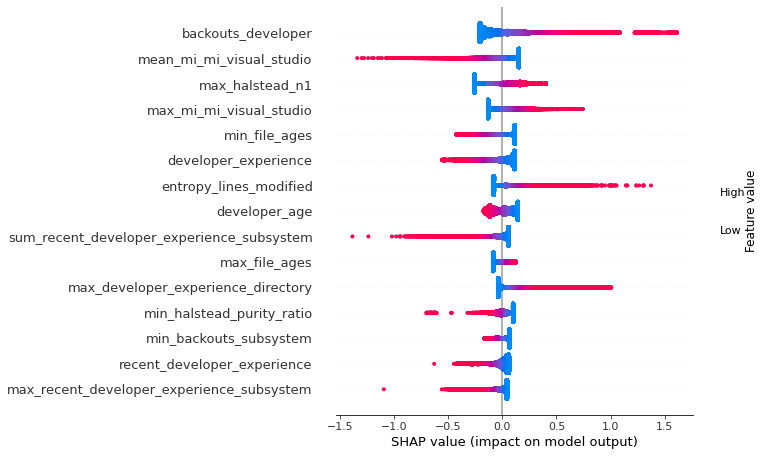

In [79]:
X_train_scaled = perf_pipeline['scaler'].transform(X_train)
perf_model = perf_pipeline['model']

plot_important_features(perf_model, X_train_scaled, features.columns, max_display=15)

best F1: 0.1712707182320442 at precision=0.1712707182320442 recall=0.1712707182320442


invalid value encountered in true_divide


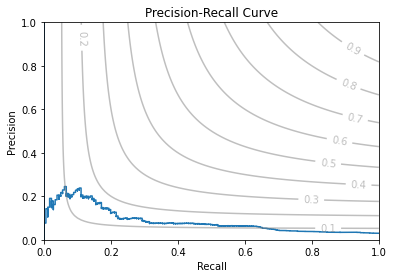

threshold=0.7591930709879939
              precision    recall  f1-score   support

           0       0.97      0.97      0.97      5856
           1       0.15      0.18      0.16       181

    accuracy                           0.94      6037
   macro avg       0.56      0.57      0.57      6037
weighted avg       0.95      0.94      0.95      6037

roc_auc=0.6859706623796153 average_precision=0.08578758641029414


4.9185019222445705

In [80]:
plot_precision_recall_curve_with_f1(perf_pipeline, X_test, y_test)
t, f1 = get_best_f1_threshold(perf_pipeline, X_train, y_train)
print_classification_report_at_threshold(perf_pipeline, X_test, y_test, t)

y_score = get_y_score(perf_pipeline, X_test)
p = metrics.precision_score(y_test, y_score >= t)
p / y_test.mean()

In [81]:
target = 'regression'

X, y, features = data_map[feature_type][data](target)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=False)

reg_pipeline = fit_best_model(model, data, feature_type, target, scoring, X_train, y_train)

regression: 11552 positive 19.14% - negative 48810 80.86%
X.shape=(60362, 302)

lr
{'model': LogisticRegression(C=0.021059163929894, random_state=0, solver='saga'), 'model__C': 5.402024656860861, 'model__penalty': 'l2', 'sampler': RandomOverSampler(random_state=0)}


The max_iter was reached which means the coef_ did not converge


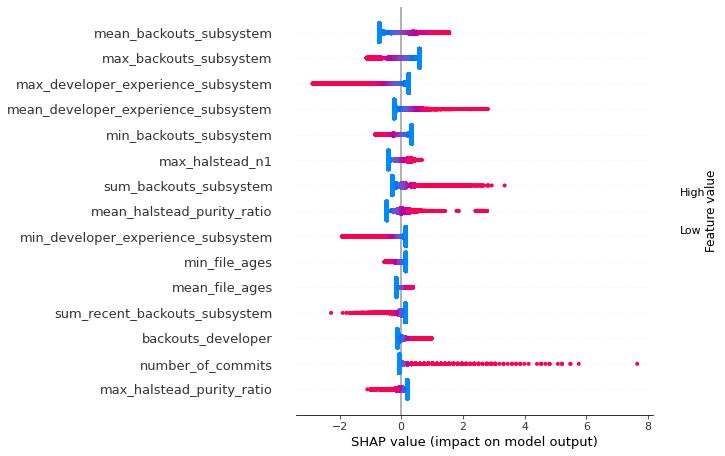

In [82]:
X_train_scaled = reg_pipeline['scaler'].transform(X_train)
reg_model = reg_pipeline['model']

plot_important_features(reg_model, X_train_scaled, features.columns, max_display=15)

best F1: 0.4009433962264151 at precision=0.30115146147032773 recall=0.599647266313933


invalid value encountered in true_divide


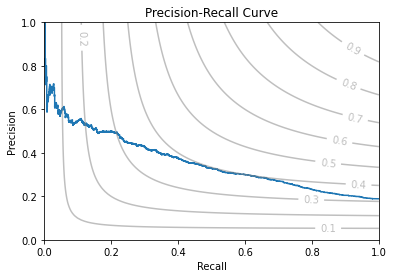

threshold=0.5208349722252273
              precision    recall  f1-score   support

           0       0.87      0.73      0.80      4903
           1       0.32      0.53      0.40      1134

    accuracy                           0.70      6037
   macro avg       0.59      0.63      0.60      6037
weighted avg       0.77      0.70      0.72      6037

roc_auc=0.6773532635419915 average_precision=0.3607692523323134


1.677767974481836

In [83]:
plot_precision_recall_curve_with_f1(reg_pipeline, X_test, y_test)
t, f1 = get_best_f1_threshold(reg_pipeline, X_train, y_train)
print_classification_report_at_threshold(reg_pipeline, X_test, y_test, t)

y_score = get_y_score(reg_pipeline, X_test)
p = metrics.precision_score(y_test, y_score >= t)
p / y_test.mean()

In [104]:
data = 'bugbug_buglevel'
scoring = 'average_precision'
feature_type = 'bow'
model = 'lr'

target = 'performance'

X, y, features_names = data_map[feature_type][data](target)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=False)

perf_pipeline = fit_best_model(model, data, feature_type, target, scoring, X_train, y_train)

performance: 1452 positive 2.41% - negative 58910 97.59%
X.shape=(60362, 50000)

lr
{'model': LogisticRegression(C=0.1881173731646983, random_state=0, solver='saga'), 'model__C': 0.6176851478255081, 'model__penalty': 'l2', 'sampler': None}


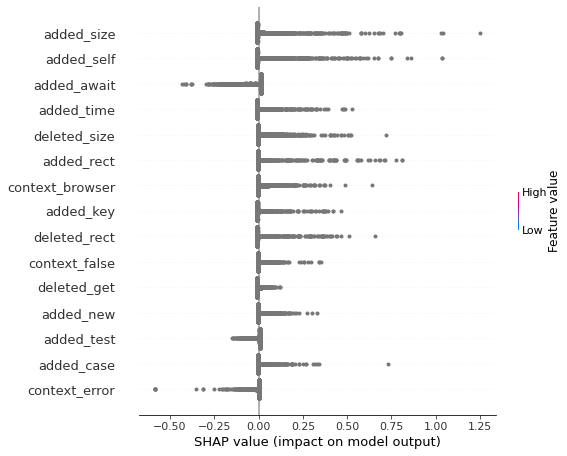

In [105]:
perf_model = perf_pipeline['model']
plot_important_features(perf_model, X_test, features_names, max_display=15)

best F1: 0.13953488372093023 at precision=0.175 recall=0.11602209944751381


invalid value encountered in true_divide


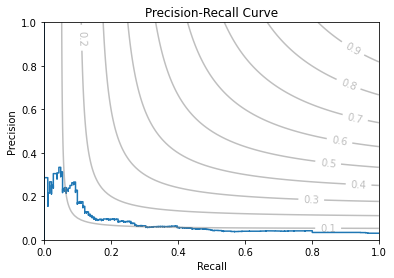

threshold=0.08291349319673007
              precision    recall  f1-score   support

           0       0.97      0.98      0.97      5856
           1       0.14      0.12      0.13       181

    accuracy                           0.95      6037
   macro avg       0.56      0.55      0.55      6037
weighted avg       0.95      0.95      0.95      6037

roc_auc=0.6444115493765661 average_precision=0.07641096540835493


4.67375162754689

In [106]:
plot_precision_recall_curve_with_f1(perf_pipeline, X_test, y_test)
t, f1 = get_best_f1_threshold(perf_pipeline, X_train, y_train)
print_classification_report_at_threshold(perf_pipeline, X_test, y_test, t)

y_score = get_y_score(perf_pipeline, X_test)
p = metrics.precision_score(y_test, y_score >= t)
p / y_test.mean()

In [101]:
target = 'regression'

X, y, features = data_map[feature_type][data](target)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=False)

reg_pipeline = fit_best_model(model, data, feature_type, target, scoring, X_train, y_train)

regression: 11552 positive 19.14% - negative 48810 80.86%
X.shape=(60362, 50000)

lr
{'model': LogisticRegression(C=0.6176851478255081, random_state=0, solver='saga'), 'model__C': 0.1881173731646983, 'model__penalty': 'l2', 'sampler': None}


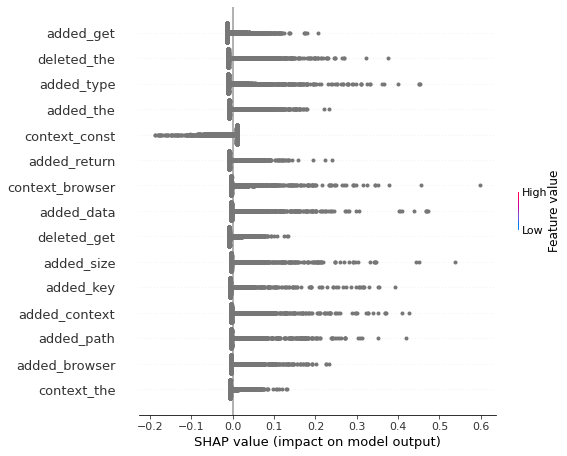

In [102]:
reg_model = reg_pipeline['model']
plot_important_features(reg_model, X_test, features_names, max_display=15)

best F1: 0.36358574610244987 at precision=0.2656631407648495 recall=0.5758377425044092


invalid value encountered in true_divide


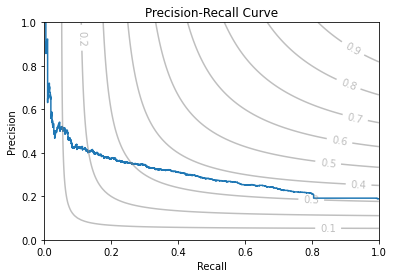

threshold=0.24531288661846556
              precision    recall  f1-score   support

           0       0.85      0.81      0.83      4903
           1       0.32      0.38      0.35      1134

    accuracy                           0.73      6037
   macro avg       0.58      0.60      0.59      6037
weighted avg       0.75      0.73      0.74      6037

roc_auc=0.6306445573221017 average_precision=0.30538359434105167


1.6778916413387486

In [103]:
plot_precision_recall_curve_with_f1(reg_pipeline, X_test, y_test)
t, f1 = get_best_f1_threshold(reg_pipeline, X_train, y_train)
print_classification_report_at_threshold(reg_pipeline, X_test, y_test, t)

y_score = get_y_score(reg_pipeline, X_test)
p = metrics.precision_score(y_test, y_score >= t)
p / y_test.mean()